### Cell 1: Input Parameters and Configuration

This cell is dedicated to defining all the essential parameters that configure the Monte Carlo simulation for Financial Independence, Retire Early (FIRE) planning. These parameters are systematically categorized into deterministic inputs (representing your personal financial plan), economic assumptions (defining the stochastic variables), portfolio allocation strategies, and overall simulation control parameters.

---

The initial lines import necessary Python libraries like `numpy` for numerical operations, `pandas` for data handling, and `matplotlib.pyplot` for plotting. A crucial line sets a random seed, `np.random.seed(44)`, which ensures that the simulation results are reproducible across different runs. This means if you run the simulation multiple times with the same seed, you will get the exact same sequence of random numbers and thus the same outcomes.

---

#### A. Deterministic Inputs (Your Personal Financial Plan)

These parameters represent the fixed, known values or specific decisions made within your personal financial strategy for each simulation run.

* `I0 = 323_700`: Initial Investment Value (e.g., in EUR). This is the total capital initially allocated to investment assets, separate from the bank account.
* `b0 = 24_000`: Initial Bank Account Balance (e.g., in EUR). This is your starting cash buffer for immediate expenses.
* `REAL_BANK_LOWER_BOUND_EUROS = 15000`: A critical threshold for the bank account. This value is defined in "today's money" (real terms), representing the minimum desired real purchasing power to maintain in the bank for liquidity.
* `T_ret_years = 38`: The total duration of retirement in years.
* `T_ret_months = T_ret_years * 12`: The total retirement duration converted into months for more granular simulation steps.
* `X_real_monthly_initial = 3900`: Initial monthly expenses (in EUR/month), defined in "today's money" (real purchasing power). The nominal value of these expenses will automatically increase over time due to inflation to maintain purchasing power.
* `C_planned = [(55_000, 2), (54_000, 3), (52_000, 4)]`: A list of planned contributions to the portfolio. Each tuple contains `(real_amount, year_of_retirement_start_idx)`. The `real_amount` is in today's money. The `year_of_retirement_start_idx` is 0-indexed (e.g., index 0 means year 1 of retirement, index 1 means year 2, and so on).
* `P_real_monthly = 3900`: Initial monthly pension income (in EUR/month), also defined in "today's money" (real terms).
* `PENSION_INFLATION_ADJUSTMENT_FACTOR = 0.7`: A factor indicating how much the pension income is adjusted for inflation. A value of $0.7$ means the pension increases by $70\%$ of the actual inflation rate each year.
* `Y_P_start_idx = 5`: The 0-indexed year when the pension income begins (e.g., index 5 means pension starts in year 6 of retirement).

---

#### B. Economic Assumptions (Averages and Volatilities)

These parameters define the statistical distributions from which random annual real returns and inflation rates will be drawn for each simulation. They represent long-term average real returns ($\mu$) and standard deviations ($\sigma$) (volatility).

* **Stocks:**
    * `STOCK_MU = 0.055`: Average annual real return for stocks ($5.5\%$).
    * `STOCK_SIGMA = 0.16`: Annual real standard deviation for stocks ($16\%$).
* **Bonds:**
    * `BOND_MU = 0.01`: Average annual real return for bonds ($1.0\%$).
    * `BOND_SIGMA = 0.03`: Annual real standard deviation for bonds ($3\%$).
* **Short-Term Reserves (STR):**
    * `STR_MU = 0.001`: Average annual real return for STR ($0.1\%$).
    * `STR_SIGMA = 0.001`: Annual real standard deviation for STR ($0.1\%$), indicating very low volatility.
* **"Fun Money" / Speculative Assets:**
    * `FUN_MU = 0.26`: Average annual real return for speculative assets ($26\%$).
    * `FUN_SIGMA = 0.81`: Annual real standard deviation for speculative assets ($81\%$), indicating extremely high volatility.
* **Direct Real Estate (Italy):**
    * `REAL_ESTATE_MU = -0.01`: Average annual real return for real estate in Italy ($-1.0\%$), factoring in price appreciation minus typical maintenance costs.
    * `REAL_ESTATE_SIGMA = 0.10`: Annual real standard deviation for real estate ($10\%$).
* **Inflation:**
    * `mu_pi = 0.02`: Long-term average annual inflation rate ($2.0\%$).
    * `sigma_pi = 0.015`: Standard deviation of annual inflation ($1.5\%$).

---

#### C. Portfolio Allocations (Weights)

These parameters define the target asset allocation weights for different phases of retirement. For each phase, the sum of all asset weights must equal $1.0$.

* **Phase 1: Pre-pension/Early Retirement (Higher Growth Focus)**
    * `W_P1_STOCKS = 0.10`
    * `W_P1_BONDS = 0.30`
    * `W_P1_STR = 0.56`
    * `W_P1_FUN = 0.04`
    * `W_P1_REAL_ESTATE = 0.00`
    * An `assert` statement `assert abs(W_P1_STOCKS + W_P1_BONDS + W_P1_STR + W_P1_FUN + W_P1_REAL_ESTATE - 1.0) < 1e-9` is included to programmatically verify that these weights sum to $1.0$, preventing potential calculation errors.
* **Phase 2: Post-pension/Later Retirement (More Conservative, Includes Real Estate)**
    * `REBALANCING_YEAR_IDX = 5`: This integer specifies the 0-indexed year when the portfolio allocation strategy transitions from Phase 1 to Phase 2 (e.g., index 5 means the shift occurs at the beginning of year 6 of retirement).
    * `W_P2_STOCKS = 0.432`
    * `W_P2_BONDS = 0.108`
    * `W_P2_STR = 0.00`
    * `W_P2_FUN = 0.00`
    * `W_P2_REAL_ESTATE = 0.46`
    * Similarly, `assert abs(W_P2_STOCKS + W_P2_BONDS + W_P2_STR + W_P2_FUN + W_P2_REAL_ESTATE - 1.0) < 1e-9` verifies that these weights sum to $1.0$.

---

#### D. Simulation Parameters

These parameters control the overarching execution of the Monte Carlo simulation.

* `num_simulations = 10000`: This integer specifies the total number of independent Monte Carlo trials that will be run. A higher number of simulations generally leads to more statistically robust and reliable results regarding the probability of success or failure.

In [ ]:
# --- 1. Input parameters
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set a random seed for reproducibility of simulation results
# Comment out or change for different simulation outcomes
np.random.seed(42) 

# --- 0. Configuration and Simulation Parameters ---

# --- A. Deterministic Inputs (Your Personal Financial Plan) ---
I0 = 123_700         # Initial Investment Value (e.g., EUR)
b0 = 24_000          # Initial Bank Account Balance (e.g., EUR)
REAL_BANK_LOWER_BOUND_EUROS = 10_000 # Example: Keep at least 15,000 EUR in today's money in the bank
T_ret_years = 38    # Retirement Duration in years
T_ret_months = T_ret_years * 12

X_real_monthly_initial = 3300 # EUR/month, in today's money (real purchasing power)

# Planned Contributions (real_amount, year_of_retirement_start_idx)
# Year_of_retirement_start_idx: 0 means year 1, 1 means year 2, etc.
C_planned = [(55_000, 2), (54_000, 3), (52_000, 4)] # (EUR, year) in real terms

# Planned Extra Expenses (real_amount, year_of_retirement_start_idx) # <--- NEW ADDITION
# Year_of_retirement_start_idx: 0 means year 1, 1 means year 2, etc.
X_planned_extra = [(0, 6)] # (EUR, year) in real terms - Example values

# Pension Income (real_amount, year_of_retirement_start_idx)
P_real_monthly = 3900 # EUR/month, in today's money
PENSION_INFLATION_ADJUSTMENT_FACTOR = 0.6
Y_P_start_idx = 5    # Pension starts in year 6 of retirement (index 5)

# --- B. Economic Assumptions (Averages and Volatilities) ---
# Long-term average annual real returns and standard deviations
# Note: These are 'real' returns, inflation adjusted.
# Rationale: Values reflect long-term historical global equity real returns and volatility
# (e.g., from Credit Suisse Global Investment Returns Yearbook).
STOCK_MU = 0.055   # Global Stocks (e.g., MSCI World) - 5.5% average annual real return
STOCK_SIGMA = 0.16 # 16% annual real standard deviation (volatility)

# Rationale: Values reflect long-term historical Eurozone investment-grade bond real returns
# and volatility, indicating modest returns and low risk (e.g., historical real yields around 1%).
BOND_MU = 0.01    # Eurozone Investment Grade Bonds - 1.0% average annual real return (recommended)
BOND_SIGMA = 0.03 # 3% annual real standard deviation (volatility)

# Rationale: Reflects long-term historical real returns and very low volatility for Eurozone cash
# equivalents, typically tracking short-term central bank rates minus inflation.
STR_MU = 0.001     # Euro Short-Term Rate (Cash Equivalent) - 0.1% average annual real return
STR_SIGMA = 0.001   # 0.1% annual real standard deviation (very low volatility)

# Rationale: Represents a highly speculative portfolio (e.g., 50% Bitcoin, 50% Silver).
# The high MU reflects Bitcoin's historical growth, and the very high SIGMA reflects extreme volatility.
# Calculations based on approx. Bitcoin MU=50%, Sigma=150%; Silver MU=2%, Sigma=30%; Correlation=0.3.
FUN_MU = 0.26      # "Fun Money" / Speculative Assets - 26% average annual real return
FUN_SIGMA = 0.81   # 81% annual real standard deviation (extremely high volatility)

# Rationale: For Italian real estate considering only price appreciation minus maintenance costs (no rentals).
# MU accounts for typical low real price growth (e.g., 1%) minus annual maintenance costs (e.g., 2%).
# SIGMA reflects historical volatility of real estate price changes in Italy.
REAL_ESTATE_MU = -0.01 # Direct Real Estate (Italy) - -1.0% average annual real return (price gain - maintenance)
REAL_ESTATE_SIGMA = 0.10 # 10% annual real standard deviation (volatility)

# Inflation
# Rationale: Reflects the European Central Bank's long-term inflation target for the Eurozone
# and historical annual inflation volatility in Italy.
mu_pi = 0.02       # Long-term average annual inflation rate (e.g., CPI) - 2.0%
sigma_pi = 0.015   # Standard deviation of annual inflation - 1.5%

# --- C. Portfolio Allocations (Weights) ---
# Ensure weights sum to 1.0 for each phase
# Phase 1: Pre-pension/early retirement, higher growth focus
W_P1_STOCKS = 0.10
W_P1_BONDS = 0.30
W_P1_STR = 0.56
W_P1_FUN = 0.04
W_P1_REAL_ESTATE = 0.00 # Real Estate is initialized to zero in Phase 1
assert abs(W_P1_STOCKS + W_P1_BONDS + W_P1_STR + W_P1_FUN + W_P1_REAL_ESTATE - 1.0) < 1e-9, "Phase 1 portfolio weights must sum to 1.0"

# Phase 2: Post-pension/later retirement, more conservative, includes Real Estate, STR
REBALANCING_YEAR_IDX = 5 # Year index when rebalancing occurs (e.g., year 6 of retirement, index 5)
# W_P2_STOCKS = 0.432
# W_P2_BONDS = 0.108
# W_P2_STR = 0.00 
# W_P2_FUN = 0.00
# W_P2_REAL_ESTATE = 0.46

# W_P2_STOCKS = 0.30
# W_P2_BONDS = 0.03
# W_P2_STR = 0.00 
# W_P2_FUN = 0.00
# W_P2_REAL_ESTATE = 0.67

# W_P2_STOCKS = 0.03
# W_P2_BONDS = 0.30
# W_P2_STR = 0.00 
# W_P2_FUN = 0.00
# W_P2_REAL_ESTATE = 0.67

W_P2_STOCKS = 0.80
W_P2_BONDS = 0.10
W_P2_STR = 0.00 
W_P2_FUN = 0.10
W_P2_REAL_ESTATE = 0.00

assert abs(W_P2_STOCKS + W_P2_BONDS + W_P2_STR + W_P2_FUN + W_P2_REAL_ESTATE - 1.0) < 1e-9, "Phase 2 portfolio weights must sum to 1.0"

# --- D. Simulation Parameters ---
num_simulations = 10000 # Number of Monte Carlo trials

In [25]:
# --- 2. Helper function to convert arithmetic mean/std dev to log-normal parameters ---
def calculate_lognormal_params(arith_mu, arith_sigma):
    """Converts arithmetic mean and std dev to log-normal distribution parameters."""
    if arith_sigma < 0:
        raise ValueError("Standard deviation cannot be negative.")
    
    # Handle cases where (1 + arith_mu) is zero or very close to zero, or where std dev is very small
    # Added a small epsilon to avoid division by zero or log of zero/negative values for numerical stability
    epsilon = 1e-10 
    
    term_for_mu_log_numerator = (1 + arith_mu) 
    term_for_mu_log_denominator_inside_sqrt = arith_sigma**2 + (1 + arith_mu)**2
    
    term_for_sigma_log_inner_log = 1 + arith_sigma**2 / ((1 + arith_mu)**2 + epsilon) # Added epsilon here
    
    if term_for_mu_log_denominator_inside_sqrt <= 0:
        raise ValueError(f"Invalid arithmetic mean ({arith_mu}) and sigma ({arith_sigma}) for log-normal conversion: denominator for mu_log too small.")
    if term_for_sigma_log_inner_log <= 0:
         raise ValueError(f"Invalid arithmetic mean ({arith_mu}) and sigma ({arith_sigma}) for log-normal conversion: argument to sigma_log inner log too small.")
         
    mu_log = np.log(term_for_mu_log_numerator**2 / np.sqrt(term_for_mu_log_denominator_inside_sqrt))
    sigma_log = np.sqrt(np.log(term_for_sigma_log_inner_log))
    return mu_log, sigma_log

# --- Calculate Portfolio Parameters based on Allocations (Derived from above) ---

print("--- Derived Portfolio Parameters ---")

# --- Portfolio Phase 1 Derived Parameters ---
arith_mu_r_phase1 = (W_P1_STOCKS * STOCK_MU) + \
                    (W_P1_BONDS * BOND_MU) + \
                    (W_P1_STR * STR_MU) + \
                    (W_P1_FUN * FUN_MU) + \
                    (W_P1_REAL_ESTATE * REAL_ESTATE_MU)

arith_sigma_r_phase1 = np.sqrt(
    (W_P1_STOCKS * STOCK_SIGMA)**2 + \
    (W_P1_BONDS * BOND_SIGMA)**2 + \
    (W_P1_STR * STR_SIGMA)**2 + \
    (W_P1_FUN * FUN_SIGMA)**2 + \
    (W_P1_REAL_ESTATE * REAL_ESTATE_SIGMA)**2
)
mu_log_r_phase1, sigma_log_r_phase1 = calculate_lognormal_params(
    arith_mu_r_phase1, arith_sigma_r_phase1
)
print(f"Phase 1 Portfolio: Arith Mean={arith_mu_r_phase1:.4f}, Arith StdDev={arith_sigma_r_phase1:.4f}")
print(f"Phase 1 Lognormal: Mu_log={mu_log_r_phase1:.4f}, Sigma_log={sigma_log_r_phase1:.4f}\n")


# --- Portfolio Phase 2 Derived Parameters (now includes Real Estate and STR) ---
arith_mu_r_phase2 = (W_P2_STOCKS * STOCK_MU) + \
                    (W_P2_BONDS * BOND_MU) + \
                    (W_P2_STR * STR_MU) + \
                    (W_P2_FUN * FUN_MU) + \
                    (W_P2_REAL_ESTATE * REAL_ESTATE_MU)

arith_sigma_r_phase2 = np.sqrt(
    (W_P2_STOCKS * STOCK_SIGMA)**2 + \
    (W_P2_BONDS * BOND_SIGMA)**2 + \
    (W_P2_STR * STR_SIGMA)**2 + \
    (W_P2_FUN * FUN_SIGMA)**2 + \
    (W_P2_REAL_ESTATE * REAL_ESTATE_SIGMA)**2
)
mu_log_r_phase2, sigma_log_r_phase2 = calculate_lognormal_params(
    arith_mu_r_phase2, arith_sigma_r_phase2
)
print(f"Phase 2 Portfolio (with Real Estate & STR): Arith Mean={arith_mu_r_phase2:.4f}, Arith StdDev={arith_sigma_r_phase2:.4f}")
print(f"Phase 2 (with Real Estate & STR) Lognormal: Mu_log={mu_log_r_phase2:.4f}, Sigma_log={sigma_log_r_phase2:.4f}\n")


# --- NEW: Calculate Log-normal Parameters for Individual Asset Classes ---
print("--- Individual Asset Class Log-normal Parameters ---")

mu_log_stocks, sigma_log_stocks = calculate_lognormal_params(STOCK_MU, STOCK_SIGMA)
print(f"Stocks: Mu_log={mu_log_stocks:.4f}, Sigma_log={sigma_log_stocks:.4f}")

mu_log_bonds, sigma_log_bonds = calculate_lognormal_params(BOND_MU, BOND_SIGMA)
print(f"Bonds: Mu_log={mu_log_bonds:.4f}, Sigma_log={sigma_log_bonds:.4f}")

mu_log_str, sigma_log_str = calculate_lognormal_params(STR_MU, STR_SIGMA)
print(f"STR: Mu_log={mu_log_str:.4f}, Sigma_log={sigma_log_str:.4f}")

mu_log_fun, sigma_log_fun = calculate_lognormal_params(FUN_MU, FUN_SIGMA)
print(f"Fun Money: Mu_log={mu_log_fun:.4f}, Sigma_log={sigma_log_fun:.4f}")

mu_log_real_estate, sigma_log_real_estate = calculate_lognormal_params(REAL_ESTATE_MU, REAL_ESTATE_SIGMA)
print(f"Real Estate: Mu_log={mu_log_real_estate:.4f}, Sigma_log={sigma_log_real_estate:.4f}\n")


# --- NEW: Calculate Initial Investment Values for Each Asset Class ---
# These are based on I0 and Phase 1 weights, as per user's request.
print("--- Initial Asset Class Values ---")
initial_stocks_value = I0 * W_P1_STOCKS
initial_bonds_value = I0 * W_P1_BONDS
initial_str_value = I0 * W_P1_STR
initial_fun_value = I0 * W_P1_FUN
initial_real_estate_value = I0 * W_P1_REAL_ESTATE

print(f"Initial Stocks Value: {initial_stocks_value:,.2f} EUR")
print(f"Initial Bonds Value: {initial_bonds_value:,.2f} EUR")
print(f"Initial STR Value: {initial_str_value:,.2f} EUR")
print(f"Initial Fun Money Value: {initial_fun_value:,.2f} EUR")
print(f"Initial Real Estate Value: {initial_real_estate_value:,.2f} EUR\n")


# --- General Helper Functions ---

def annual_to_monthly_compounded_rate(annual_rate):
    """Converts an annual rate to its equivalent monthly compounded rate."""
    return (1 + annual_rate)**(1/12) - 1

def inflate_amount_over_years(base_real_amount, years_passed, annual_inflation_rates_sequence):
    """
    Inflates a real amount to its nominal value after 'years_passed'
    using a sequence of annual inflation rates specific to this simulation trial.
    """
    if years_passed <= 0:
        return base_real_amount
    
    nominal_amount = base_real_amount
    for year_idx_passed in range(years_passed):
        if year_idx_passed < len(annual_inflation_rates_sequence):
            nominal_amount *= (1 + annual_inflation_rates_sequence[year_idx_passed])
        else:
            nominal_amount *= (1 + mu_pi) # Fallback to average inflation if sequence runs out
    return nominal_amount

--- Derived Portfolio Parameters ---
Phase 1 Portfolio: Arith Mean=0.0195, Arith StdDev=0.0372
Phase 1 Lognormal: Mu_log=0.0186, Sigma_log=0.0365

Phase 2 Portfolio (with Real Estate & STR): Arith Mean=0.0710, Arith StdDev=0.1515
Phase 2 (with Real Estate & STR) Lognormal: Mu_log=0.0587, Sigma_log=0.1408

--- Individual Asset Class Log-normal Parameters ---
Stocks: Mu_log=0.0422, Sigma_log=0.1508
Bonds: Mu_log=0.0095, Sigma_log=0.0297
STR: Mu_log=0.0010, Sigma_log=0.0010
Fun Money: Mu_log=0.0582, Sigma_log=0.5881
Real Estate: Mu_log=-0.0151, Sigma_log=0.1008

--- Initial Asset Class Values ---
Initial Stocks Value: 12,370.00 EUR
Initial Bonds Value: 37,110.00 EUR
Initial STR Value: 69,272.00 EUR
Initial Fun Money Value: 4,948.00 EUR
Initial Real Estate Value: 0.00 EUR



In [26]:
# Cell 3: Monte Carlo Simulation Function

def run_single_fire_simulation(
    b0,
    initial_stocks_value, initial_bonds_value, initial_str_value, initial_fun_value, initial_real_estate_value, # New individual asset initial values
    T_ret_months, T_ret_years,
    X_real_monthly_initial,
    C_planned,
    X_planned_extra, # <--- NEW: Added X_planned_extra parameter
    P_real_monthly, PENSION_INFLATION_ADJUSTMENT_FACTOR, Y_P_start_idx,
    mu_pi, sigma_pi,
    REBALANCING_YEAR_IDX,
    W_P1_STOCKS, W_P1_BONDS, W_P1_STR, W_P1_FUN, W_P1_REAL_ESTATE,
    W_P2_STOCKS, W_P2_BONDS, W_P2_STR, W_P2_FUN, W_P2_REAL_ESTATE,
    mu_log_stocks, sigma_log_stocks,
    mu_log_bonds, sigma_log_bonds,
    mu_log_str, sigma_log_str,
    mu_log_fun, sigma_log_fun,
    mu_log_real_estate, sigma_log_real_estate,
    real_bank_lower_bound
):
    # Initialize balances and history
    current_b = b0
    current_stocks = initial_stocks_value
    current_bonds = initial_bonds_value
    current_str = initial_str_value
    current_fun = initial_fun_value
    current_real_estate = initial_real_estate_value

    nominal_wealth_history = []
    bank_balance_history = [] 
    annual_inflations_seq = np.zeros(T_ret_years)

    success = True
    months_lasted = 0

    # Variables to store rebalancing and final allocations
    pre_rebalancing_allocations_nominal = {}
    pre_rebalancing_allocations_real = {}
    rebalancing_allocations_nominal = {}
    rebalancing_allocations_real = {}
    final_allocations_nominal = {}
    final_allocations_real = {}

    # Pre-generate full sequence of annual returns for each asset and inflation
    # for the entire retirement duration of this single simulation trial
    annual_inflations_seq = np.random.lognormal(
        np.log(1 + mu_pi) - 0.5 * sigma_pi**2, sigma_pi, T_ret_years
    ) - 1

    # Generate annual returns for each asset class
    annual_stocks_returns_seq = np.random.lognormal(
        mu_log_stocks, sigma_log_stocks, T_ret_years
    ) - 1
    annual_bonds_returns_seq = np.random.lognormal(
        mu_log_bonds, sigma_log_bonds, T_ret_years
    ) - 1
    annual_str_returns_seq = np.random.lognormal(
        mu_log_str, sigma_log_str, T_ret_years
    ) - 1
    annual_fun_returns_seq = np.random.lognormal(
        mu_log_fun, sigma_log_fun, T_ret_years
    ) - 1
    annual_real_estate_returns_seq = np.random.lognormal(
        mu_log_real_estate, sigma_log_real_estate, T_ret_years
    ) - 1

    # Pre-calculate nominal planned contributions and pension start year based on this trial's inflation
    nominal_c_planned_amounts = []
    for real_amount, year_idx in C_planned:
        nominal_c_amount = inflate_amount_over_years(
            real_amount, year_idx, annual_inflations_seq
        )
        nominal_c_planned_amounts.append((nominal_c_amount, year_idx))

    # Pre-calculate nominal planned extra expenses based on this trial's inflation # <--- NEW ADDITION BLOCK
    nominal_x_planned_extra_amounts = []
    # Create a local mutable copy to safely remove items after they're applied
    # This ensures the original X_planned_extra list passed from the calling scope isn't modified
    local_x_planned_extra = list(X_planned_extra) 
    for real_amount, year_idx in local_x_planned_extra: # Iterate over the local copy
        nominal_x_amount = inflate_amount_over_years(
            real_amount, year_idx, annual_inflations_seq
        )
        nominal_x_planned_extra_amounts.append((nominal_x_amount, year_idx))
    # <--- END NEW ADDITION BLOCK

    nominal_pension_start_amount = inflate_amount_over_years(
        P_real_monthly, Y_P_start_idx, annual_inflations_seq
    )

    # Simulation loop
    for current_month_idx in range(T_ret_months):
        months_lasted += 1
        current_year_idx = current_month_idx // 12
        month_in_year_idx = current_month_idx % 12

        # 1. Add pension if applicable (starts at the beginning of the pension year)
        nominal_pension_monthly = 0
        if current_year_idx >= Y_P_start_idx:
            # Adjust pension by its specific inflation factor from start year
            pension_inflation_factor = np.prod(1 + (annual_inflations_seq[Y_P_start_idx:current_year_idx] * PENSION_INFLATION_ADJUSTMENT_FACTOR)) if current_year_idx > Y_P_start_idx else 1
            
            nominal_pension_monthly = nominal_pension_start_amount * pension_inflation_factor
            current_b += nominal_pension_monthly # Pension directly to bank account

        # --- NEW LOGIC: Check and Top-Up Bank Account if below Real Lower Bound ---
        # Calculate current cumulative inflation factor for real value assessment
        monthly_inflation_rate_this_year = annual_to_monthly_compounded_rate(annual_inflations_seq[current_year_idx])
        cumulative_inflation_factor_up_to_current_month = np.prod(1 + annual_inflations_seq[:current_year_idx]) * ((1 + monthly_inflation_rate_this_year)**(month_in_year_idx + 1))
        
        real_current_b = current_b / cumulative_inflation_factor_up_to_current_month

        if real_current_b < real_bank_lower_bound:
            real_shortfall_to_cover = real_bank_lower_bound - real_current_b
            nominal_top_up_amount = real_shortfall_to_cover * cumulative_inflation_factor_up_to_current_month

            amount_to_liquidate_for_top_up = nominal_top_up_amount

            # Withdraw from STR (priority 1)
            if amount_to_liquidate_for_top_up > 0:
                if current_str >= amount_to_liquidate_for_top_up:
                    current_str -= amount_to_liquidate_for_top_up
                    current_b += amount_to_liquidate_for_top_up
                    amount_to_liquidate_for_top_up = 0
                else:
                    current_b += current_str # Take all of STR
                    amount_to_liquidate_for_top_up -= current_str
                    current_str = 0

            # Withdraw from Bonds (priority 2)
            if amount_to_liquidate_for_top_up > 0:
                if current_bonds >= amount_to_liquidate_for_top_up:
                    current_bonds -= amount_to_liquidate_for_top_up
                    current_b += amount_to_liquidate_for_top_up
                    amount_to_liquidate_for_top_up = 0
                else:
                    current_b += current_bonds # Take all of Bonds
                    amount_to_liquidate_for_top_up -= current_bonds
                    current_bonds = 0

            # Withdraw from Stocks (priority 3)
            if amount_to_liquidate_for_top_up > 0:
                if current_stocks >= amount_to_liquidate_for_top_up:
                    current_stocks -= amount_to_liquidate_for_top_up
                    current_b += amount_to_liquidate_for_top_up
                    amount_to_liquidate_for_top_up = 0
                else:
                    current_b += current_stocks # Take all of Stocks
                    amount_to_liquidate_for_top_up -= current_stocks
                    current_stocks = 0

            # Withdraw from Fun Money (priority 4)
            if amount_to_liquidate_for_top_up > 0:
                if current_fun >= amount_to_liquidate_for_top_up:
                    current_fun -= amount_to_liquidate_for_top_up
                    current_b += amount_to_liquidate_for_top_up
                    amount_to_liquidate_for_top_up = 0
                else:
                    current_b += current_fun # Take all of Fun Money
                    amount_to_liquidate_for_top_up -= current_fun
                    current_fun = 0

            # CRITICAL FAILURE CHECK: If still needed after all liquid assets (excluding Real Estate)
            if amount_to_liquidate_for_top_up > 0:
                success = False
                break # Simulation failed, exit loop
        # --- END NEW LOGIC ---

        # 2. Handle planned contributions
        for nominal_c_amount, c_year_idx in nominal_c_planned_amounts:
            if current_year_idx == c_year_idx and month_in_year_idx == 0: # Apply contribution at start of the year
                # Determine current portfolio weights for contribution allocation
                if current_year_idx < REBALANCING_YEAR_IDX:
                    current_W_STOCKS = W_P1_STOCKS
                    current_W_BONDS = W_P1_BONDS
                    current_W_STR = W_P1_STR
                    current_W_FUN = W_P1_FUN
                    current_W_REAL_ESTATE = W_P1_REAL_ESTATE
                else:
                    current_W_STOCKS = W_P2_STOCKS
                    current_W_BONDS = W_P2_BONDS
                    current_W_STR = W_P2_STR
                    current_W_FUN = W_P2_FUN
                    current_W_REAL_ESTATE = W_P2_REAL_ESTATE
                
                # Allocate contribution across assets based on weights
                current_stocks += nominal_c_amount * current_W_STOCKS
                current_bonds += nominal_c_amount * current_W_BONDS
                current_str += nominal_c_amount * current_W_STR
                current_fun += nominal_c_amount * current_W_FUN
                current_real_estate += nominal_c_amount * current_W_REAL_ESTATE

        # 3. Calculate nominal monthly withdrawal amount (includes X_real_monthly_initial)
        # Inflate the initial real withdrawal to current month's nominal value
        nominal_x_monthly = inflate_amount_over_years(
            X_real_monthly_initial,
            current_year_idx,
            annual_inflations_seq # Use this trial's inflation sequence
        )
        
        # --- NEW ADDITION: Add planned extra expenses for this month/year ---
        extra_expense_for_this_month = 0
        expenses_to_remove_indices = [] 

        # Iterate over the pre-calculated nominal planned extra expenses
        # Note: We iterate over a copy or pre-calculated list to avoid issues when popping
        # `nominal_x_planned_extra_amounts` is already a pre-calculated list for this simulation run.
        for i, (nominal_x_amount, x_year_idx) in enumerate(nominal_x_planned_extra_amounts):
            if current_year_idx == x_year_idx and month_in_year_idx == 0: # Apply expense at start of the year
                extra_expense_for_this_month += nominal_x_amount
                expenses_to_remove_indices.append(i) # Mark for removal

        # Remove applied expenses from the list to prevent them from being applied again
        # Iterate in reverse to avoid index shifting issues when popping
        for idx in sorted(expenses_to_remove_indices, reverse=True):
            nominal_x_planned_extra_amounts.pop(idx) # This modifies the list for the current simulation run
        # <--- END NEW ADDITION

        # 4. Process monthly withdrawals (Prioritized)
        # Sum normal monthly expense and any extra planned expenses for this month
        withdrawal_needed = nominal_x_monthly + extra_expense_for_this_month # <--- MODIFIED LINE (added extra expense)
        
        # Withdraw from bank account
        if current_b >= withdrawal_needed:
            current_b -= withdrawal_needed
            withdrawal_needed = 0
        else:
            withdrawal_needed -= current_b
            current_b = 0

        # Withdraw from STR
        if withdrawal_needed > 0:
            if current_str >= withdrawal_needed:
                current_str -= withdrawal_needed
                withdrawal_needed = 0
            else:
                withdrawal_needed -= current_str
                current_str = 0
        
        # Withdraw from Bonds
        if withdrawal_needed > 0:
            if current_bonds >= withdrawal_needed:
                current_bonds -= withdrawal_needed
                withdrawal_needed = 0
            else:
                withdrawal_needed -= current_bonds
                current_bonds = 0

        # Withdraw from Stocks
        if withdrawal_needed > 0:
            if current_stocks >= withdrawal_needed:
                current_stocks -= withdrawal_needed
                withdrawal_needed = 0
            else:
                withdrawal_needed -= current_stocks
                current_stocks = 0

        # Withdraw from Fun Money
        if withdrawal_needed > 0:
            if current_fun >= withdrawal_needed:
                current_fun -= withdrawal_needed
                withdrawal_needed = 0
            else:
                withdrawal_needed -= current_fun
                current_fun = 0

        # Check for failure (if Real Estate would be needed)
        if withdrawal_needed > 0:
            success = False
            break # Exit simulation early if plan fails

        # 5. Apply monthly returns to investments (at end of month)
        # Calculate monthly returns for this year for each asset
        monthly_stocks_return = annual_to_monthly_compounded_rate(annual_stocks_returns_seq[current_year_idx])
        monthly_bonds_return = annual_to_monthly_compounded_rate(annual_bonds_returns_seq[current_year_idx])
        monthly_str_return = annual_to_monthly_compounded_rate(annual_str_returns_seq[current_year_idx])
        monthly_fun_return = annual_to_monthly_compounded_rate(annual_fun_returns_seq[current_year_idx])
        monthly_real_estate_return = annual_to_monthly_compounded_rate(annual_real_estate_returns_seq[current_year_idx])

        # Apply returns
        current_stocks *= (1 + monthly_stocks_return)
        current_bonds *= (1 + monthly_bonds_return)
        current_str *= (1 + monthly_str_return)
        current_fun *= (1 + monthly_fun_return)
        current_real_estate *= (1 + monthly_real_estate_return)
        
        # 6. Rebalance at the start of REBALANCING_YEAR_IDX
        if current_year_idx == REBALANCING_YEAR_IDX and month_in_year_idx == 0 and REBALANCING_YEAR_IDX > 0: # Ensure rebalancing only happens once at the start of the year
            total_investment_value_pre_rebalance = current_stocks + current_bonds + current_str + current_fun + current_real_estate
            
            # Calculate cumulative inflation up to rebalancing year to get real values
            cumulative_inflation_rebalance_year = np.prod(1 + annual_inflations_seq[:REBALANCING_YEAR_IDX]) if REBALANCING_YEAR_IDX > 0 else 1.0

            # Record nominal and real portfolio allocation *just before* rebalancing
            pre_rebalancing_allocations_nominal = {
                'Stocks': current_stocks,
                'Bonds': current_bonds,
                'STR': current_str,
                'Fun': current_fun,
                'Real Estate': current_real_estate
            }
            pre_rebalancing_allocations_real = {
                'Stocks': current_stocks / cumulative_inflation_rebalance_year,
                'Bonds': current_bonds / cumulative_inflation_rebalance_year,
                'STR': current_str / cumulative_inflation_rebalance_year,
                'Fun': current_fun / cumulative_inflation_rebalance_year,
                'Real Estate': current_real_estate / cumulative_inflation_rebalance_year
            }


            # Record nominal portfolio allocation just after rebalancing
            rebalancing_allocations_nominal = {
                'Stocks': total_investment_value_pre_rebalance * W_P2_STOCKS,
                'Bonds': total_investment_value_pre_rebalance * W_P2_BONDS,
                'STR': total_investment_value_pre_rebalance * W_P2_STR,
                'Fun': total_investment_value_pre_rebalance * W_P2_FUN,
                'Real Estate': total_investment_value_pre_rebalance * W_P2_REAL_ESTATE
            }

            rebalancing_allocations_real = {
                'Stocks': rebalancing_allocations_nominal['Stocks'] / cumulative_inflation_rebalance_year,
                'Bonds': rebalancing_allocations_nominal['Bonds'] / cumulative_inflation_rebalance_year,
                'STR': rebalancing_allocations_nominal['STR'] / cumulative_inflation_rebalance_year,
                'Fun': rebalancing_allocations_nominal['Fun'] / cumulative_inflation_rebalance_year,
                'Real Estate': rebalancing_allocations_nominal['Real Estate'] / cumulative_inflation_rebalance_year
            }

            current_stocks = total_investment_value_pre_rebalance * W_P2_STOCKS
            current_bonds = total_investment_value_pre_rebalance * W_P2_BONDS
            current_str = total_investment_value_pre_rebalance * W_P2_STR
            current_fun = total_investment_value_pre_rebalance * W_P2_FUN
            current_real_estate = total_investment_value_pre_rebalance * W_P2_REAL_ESTATE

        # Record nominal wealth at the end of the month
        nominal_wealth_history.append(current_b + current_stocks + current_bonds + current_str + current_fun + current_real_estate)
        bank_balance_history.append(current_b)

    # Final results for this simulation
    final_investment = current_stocks + current_bonds + current_str + current_fun + current_real_estate
    final_bank_balance = current_b

    # Record nominal and real portfolio allocation at the end of the simulation
    final_allocations_nominal = {
        'Stocks': current_stocks,
        'Bonds': current_bonds,
        'STR': current_str,
        'Fun': current_fun,
        'Real Estate': current_real_estate
    }

    # Calculate cumulative inflation for the entire simulation duration
    cumulative_inflation_end_of_sim = np.prod(1 + annual_inflations_seq) if T_ret_years > 0 else 1.0
    final_allocations_real = {
        'Stocks': current_stocks / cumulative_inflation_end_of_sim,
        'Bonds': current_bonds / cumulative_inflation_end_of_sim,
        'STR': current_str / cumulative_inflation_end_of_sim,
        'Fun': current_fun / cumulative_inflation_end_of_sim,
        'Real Estate': current_real_estate / cumulative_inflation_end_of_sim
    }

    return (success, months_lasted, final_investment, final_bank_balance, annual_inflations_seq, 
            nominal_wealth_history, bank_balance_history,
            pre_rebalancing_allocations_nominal, pre_rebalancing_allocations_real,
            rebalancing_allocations_nominal, rebalancing_allocations_real, 
            final_allocations_nominal, final_allocations_real)


# --- Run Monte Carlo Simulations ---
simulation_results = []

# Initial asset values need to be calculated once before the loop if I0 is the total.
# For now, assuming initial_stocks_value etc. are defined directly from I0 and W_P1
# This logic should be placed *before* the simulation loop in the main script or within a setup function.
# For the purpose of providing this cell, I'll put a placeholder for this common setup.
# In a full script, I0 would be distributed into initial_stocks_value, etc., based on W_P1.

# Placeholder for how initial investment I0 is distributed into asset classes for the first simulation
# This should happen only once before the main simulation loop if I0 is the total initial investment.
# If these values are already calculated and passed as arguments, this is fine.
# Assuming initial_stocks_value, initial_bonds_value etc. are already calculated from I0 and W_P1
# outside this `for` loop, as implied by your `run_single_fire_simulation` call arguments.
initial_stocks_value = I0 * W_P1_STOCKS
initial_bonds_value = I0 * W_P1_BONDS
initial_str_value = I0 * W_P1_STR
initial_fun_value = I0 * W_P1_FUN
initial_real_estate_value = I0 * W_P1_REAL_ESTATE # Assuming Real Estate can have an initial value

for _ in range(num_simulations):
    result = run_single_fire_simulation(
        b0,
        initial_stocks_value, initial_bonds_value, initial_str_value, initial_fun_value, initial_real_estate_value,
        T_ret_months, T_ret_years,
        X_real_monthly_initial,
        C_planned,
        list(X_planned_extra), # <--- NEW: Pass a COPY of X_planned_extra here to avoid modifying the original list
        P_real_monthly, PENSION_INFLATION_ADJUSTMENT_FACTOR, Y_P_start_idx,
        mu_pi, sigma_pi,
        REBALANCING_YEAR_IDX,
        W_P1_STOCKS, W_P1_BONDS, W_P1_STR, W_P1_FUN, W_P1_REAL_ESTATE,
        W_P2_STOCKS, W_P2_BONDS, W_P2_STR, W_P2_FUN, W_P2_REAL_ESTATE,
        mu_log_stocks, sigma_log_stocks,
        mu_log_bonds, sigma_log_bonds,
        mu_log_str, sigma_log_str,
        mu_log_fun, sigma_log_fun,
        mu_log_real_estate, sigma_log_real_estate,
        REAL_BANK_LOWER_BOUND_EUROS
    )
    simulation_results.append(result)

FIRE Plan Success Rate: 100.00%

Number of successful simulations: 10000
Average total wealth at end of successful simulations (Nominal): 18,206,635.64 EUR
Average total wealth at end of successful simulations (Real - Today's Money): 8,442,700.49 EUR

--- Portfolio Allocation Snapshots ---

Scenario: Worst Case (Sim ID: 6787, Nominal Final Wealth: 53,163€, Real Final Wealth: 16,570€)
  Outcome: SUCCESS

--- Allocations Just BEFORE Rebalancing (Year 6) ---
  Stocks: Nominal=24,672.75€, Real=21,680.73€
  Bonds: Nominal=60,324.23€, Real=53,008.81€
  STR: Nominal=0.00€, Real=0.00€
  Fun: Nominal=9,243.13€, Real=8,122.23€
  Real Estate: Nominal=0.00€, Real=0.00€

--- Allocations Just AFTER Rebalancing (Year 6) ---
  Stocks: Nominal=75,392.08€, Real=66,249.41€
  Bonds: Nominal=9,424.01€, Real=8,281.18€
  STR: Nominal=0.00€, Real=0.00€
  Fun: Nominal=9,424.01€, Real=8,281.18€
  Real Estate: Nominal=0.00€, Real=0.00€

--- Allocations at End of Simulation ---
  Stocks: Nominal=0.00€, Real=0.00€

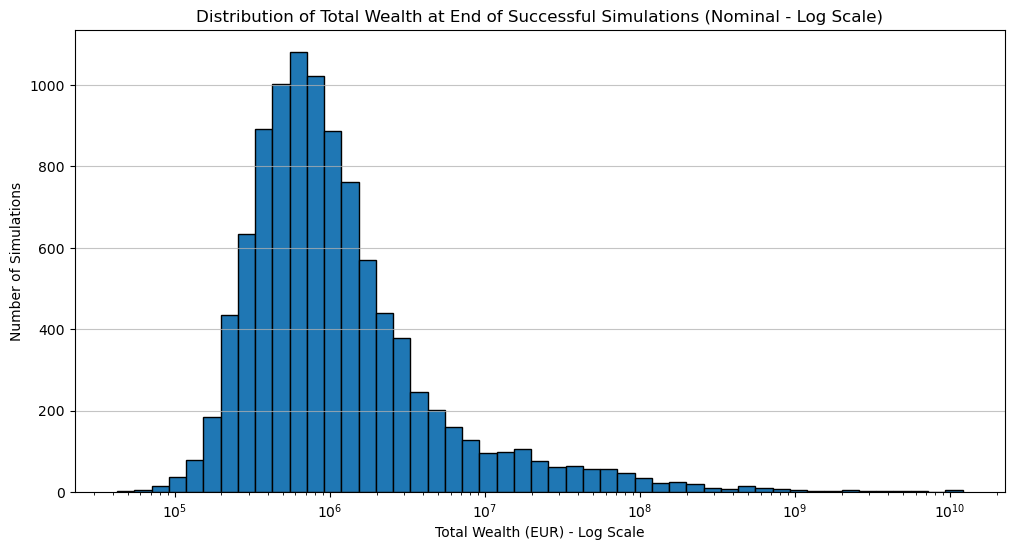

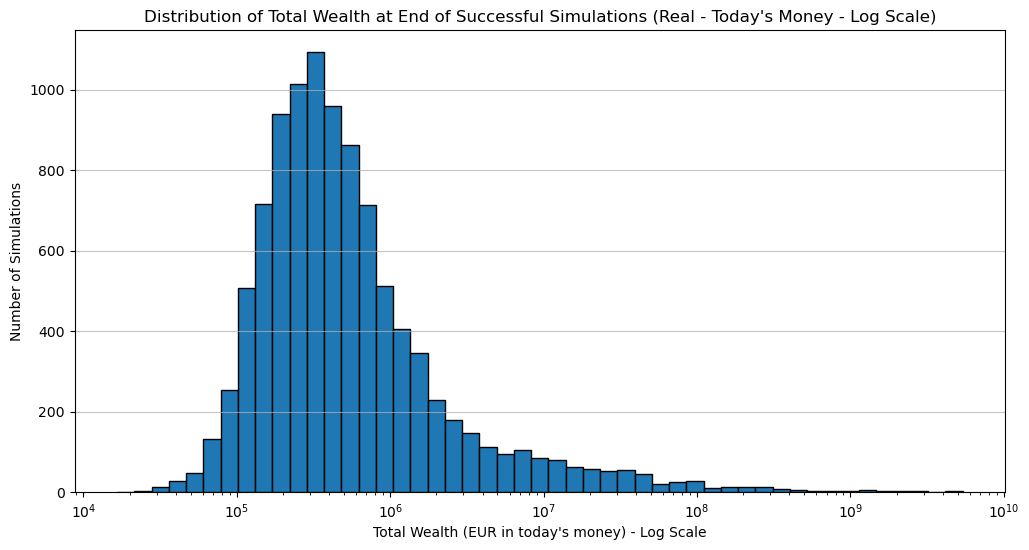


--- Time Evolution Samples ---


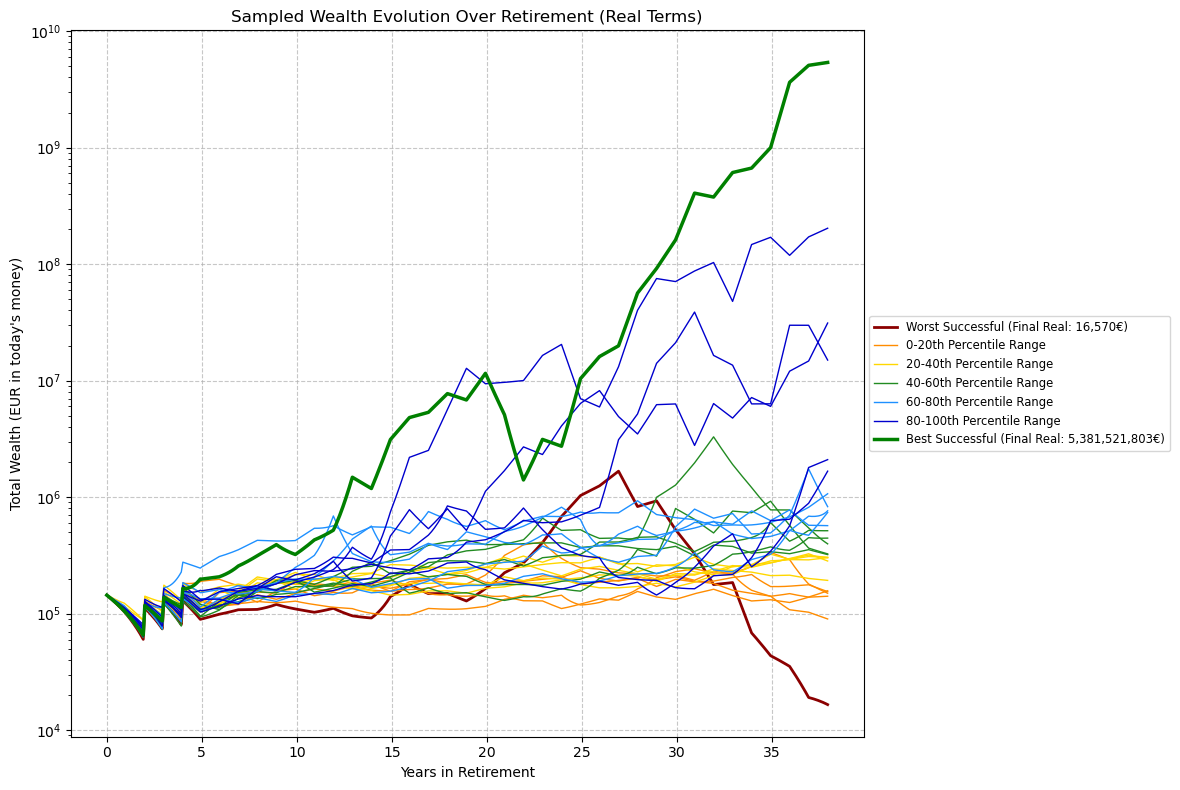

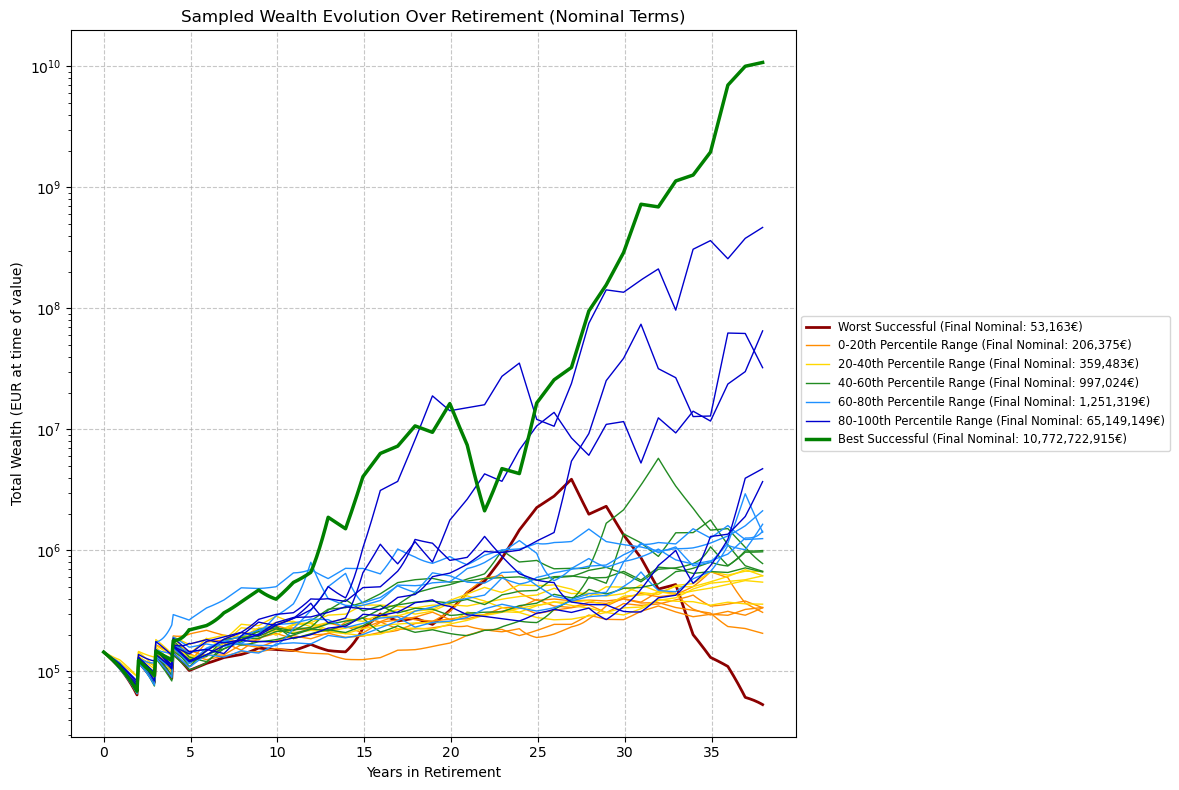


--- Sample Bank Account Trajectories (Real Terms) ---


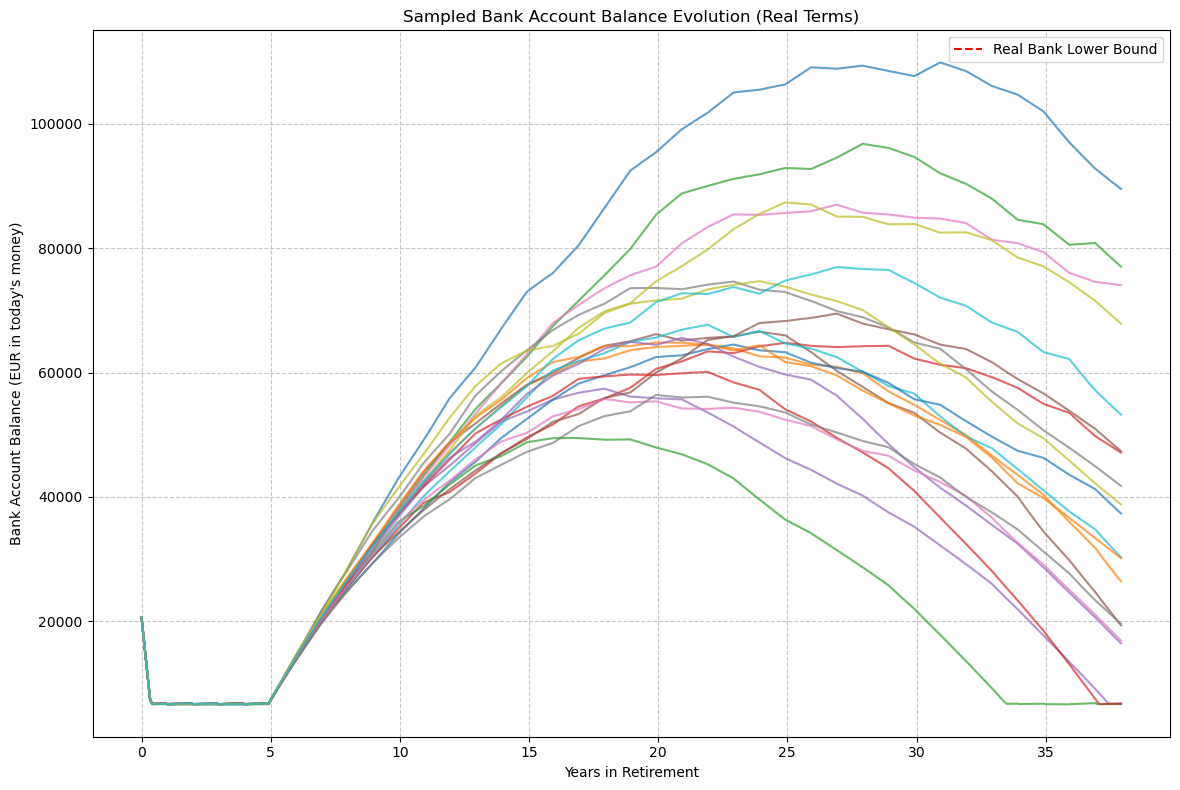


--- Sample Bank Account Trajectories (Nominal Terms) ---


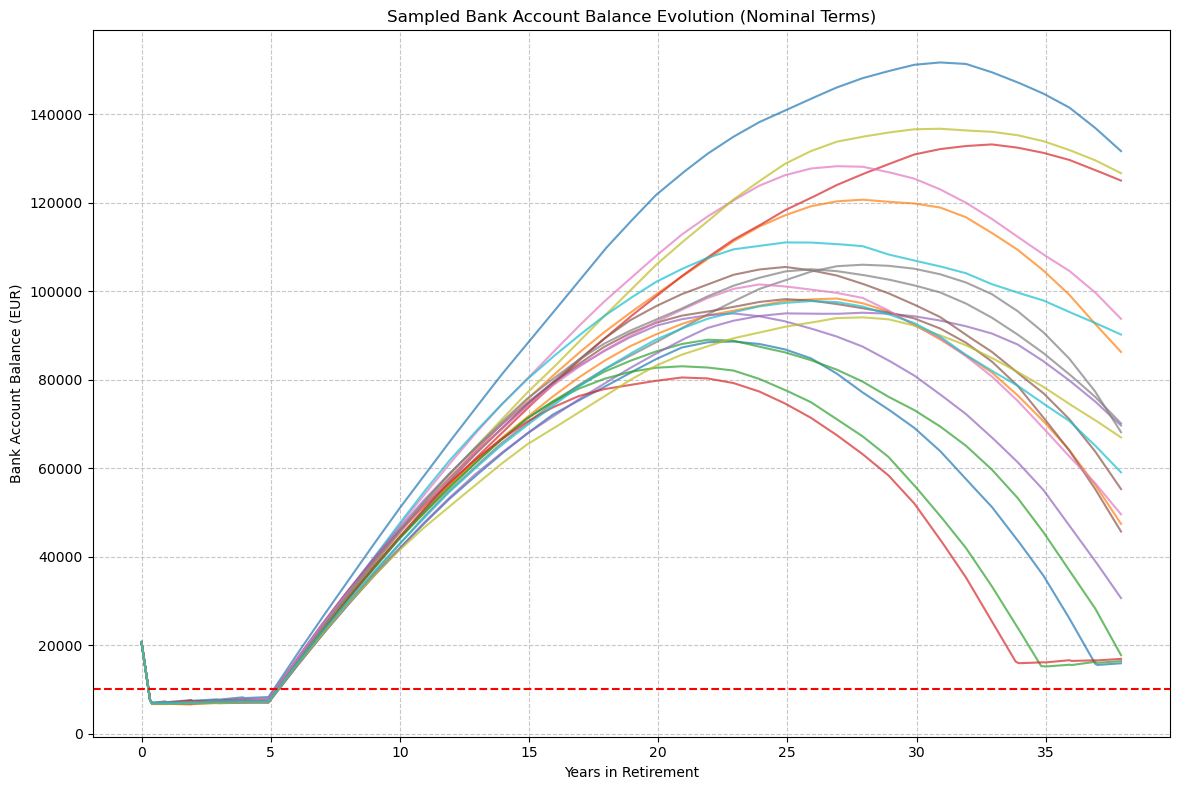

In [27]:
# --- 4. Analyze Results ---
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random # For selecting random simulations for plotting

# Updated columns to include new allocation data AND bank_balance_history
results_df = pd.DataFrame(simulation_results, columns=[
    'success', 'months_lasted', 'final_investment', 'final_bank_balance',
    'annual_inflations_seq', 'nominal_wealth_history', 'bank_balance_history', # <--- NEW: Added bank_balance_history
    'pre_rebalancing_allocations_nominal', 'pre_rebalancing_allocations_real', # NEW columns
    'rebalancing_allocations_nominal', 'rebalancing_allocations_real',
    'final_allocations_nominal', 'final_allocations_real'
])

# # --- DEBUG SNIPPET: Print Bank Account Value at Year 3 for Sampled Paths ---
# print("\n--- DEBUG: Bank Account Balance at Year 3 (Real Terms) ---")

# # Reuse plot_indices from the plotting section if available, otherwise regenerate
# # (Assuming plot_indices is generated for the 20 sampled simulations for the plot)
# if 'plot_indices' not in locals():
#     # Re-generate plot_indices if this snippet is run independently or before the plot
#     num_trajectories_to_plot = 20
#     if len(results_df) < num_trajectories_to_plot:
#         plot_indices = results_df.index.tolist()
#     else:
#         successful_sims_indices = successful_sims.index.tolist()
#         failed_sims_indices = failed_sims.index.tolist()

#         if len(successful_sims_indices) >= num_trajectories_to_plot:
#             plot_indices = np.random.choice(successful_sims_indices, num_trajectories_to_plot, replace=False)
#         else:
#             random.shuffle(failed_sims_indices)
#             plot_indices = successful_sims_indices + failed_sims_indices[:(num_trajectories_to_plot - len(successful_sims_indices))]
#             random.shuffle(plot_indices)


# target_month = 3 * 12 # Year 3 is month 36 (0-indexed means target_month will be the 37th data point if 0-indexed)

# print(f"Real Bank Lower Bound: {REAL_BANK_LOWER_BOUND_EUROS:,.2f} EUR")

# for sim_idx in plot_indices:
#     row = results_df.loc[sim_idx]
#     nominal_bank_history = row['bank_balance_history']
#     annual_inflations_seq = row['annual_inflations_seq']

#     if target_month >= len(nominal_bank_history):
#         print(f"  Sim ID {sim_idx} ({'Success' if row['success'] else 'Fail'}): Ended before Year 3. Last balance: {nominal_bank_history[-1]:,.2f} (Nominal)")
#         continue
    
#     # Get nominal bank balance at target month
#     nominal_balance_at_target_month = nominal_bank_history[target_month]
    
#     # Calculate cumulative inflation factor up to the target month
#     current_year_idx = target_month // 12
#     month_in_year_idx = target_month % 12
    
#     monthly_inflation_rate_this_year = annual_to_monthly_compounded_rate(annual_inflations_seq[current_year_idx])
    
#     if current_year_idx == 0:
#         cumulative_inflation_factor_up_to_current_month = (1 + monthly_inflation_rate_this_year)**(month_in_year_idx + 1)
#     else:
#         cumulative_inflation_factor_up_to_current_month = np.prod(1 + annual_inflations_seq[:current_year_idx]) * \
#                                                            ((1 + monthly_inflation_rate_this_year)**(month_in_year_idx + 1))
    
#     if cumulative_inflation_factor_up_to_current_month <= 0:
#          cumulative_inflation_factor_up_to_current_month = 1.0 # Safeguard against invalid factor

#     real_balance_at_target_month = nominal_balance_at_target_month / cumulative_inflation_factor_up_to_current_month

#     print(f"  Sim ID {sim_idx} ({'Success' if row['success'] else 'Fail'}): Real Bank Balance at Year 3 = {real_balance_at_target_month:,.2f} EUR")

# print("--------------------------------------------------")

# --- Calculate real_final_wealth for ALL simulations and add to results_df ---
real_final_wealths_all_sims = []
for idx, row in results_df.iterrows():
    if row['success']:
        # Only calculate for successful paths
        cumulative_inflation_factor = np.prod(1 + row['annual_inflations_seq']) if len(row['annual_inflations_seq']) > 0 else 1.0
        real_wealth = (row['final_investment'] + row['final_bank_balance']) / cumulative_inflation_factor
    else:
        # For failed simulations, set to 0 or a very low value to place them at the bottom in sorting
        real_wealth = 0
    real_final_wealths_all_sims.append(real_wealth)

results_df['real_final_wealth'] = real_final_wealths_all_sims


success_rate = results_df['success'].mean() * 100
print(f"FIRE Plan Success Rate: {success_rate:.2f}%")

failed_sims = results_df[~results_df['success']]
if not failed_sims.empty:
    print(f"\nNumber of failed simulations: {len(failed_sims)}")
    print(f"Average months lasted in failed simulations: {failed_sims['months_lasted'].mean():.1f}")
    
# Re-filter successful_sims AFTER 'real_final_wealth' has been added to results_df
successful_sims = results_df[results_df['success']]

if not successful_sims.empty:
    print(f"\nNumber of successful simulations: {len(successful_sims)}")
    
    # Calculate nominal total wealth
    nominal_total_wealth = successful_sims['final_investment'] + successful_sims['final_bank_balance']
    print(f"Average total wealth at end of successful simulations (Nominal): {nominal_total_wealth.mean():,.2f} EUR")

    average_real_final_wealth = successful_sims['real_final_wealth'].mean()
    print(f"Average total wealth at end of successful simulations (Real - Today's Money): {average_real_final_wealth:,.2f} EUR")

# --- NEW LOCATION: Print Portfolio Allocation Snapshots ---

def print_allocations(title, allocations_nominal, allocations_real):
    """Helper function to print allocation details."""
    print(f"\n--- {title} ---")
    if not allocations_nominal: # Check nominal, as real depends on it
        print("  Allocation data not available.")
        return

    for asset in allocations_nominal.keys():
        nom_val = allocations_nominal.get(asset, 0)
        real_val = allocations_real.get(asset, 0)
        print(f"  {asset}: Nominal={nom_val:,.2f}€, Real={real_val:,.2f}€")

print("\n--- Portfolio Allocation Snapshots ---")

# Identify Worst, Average, Best Cases
# Sort ALL simulations by their real final wealth
all_sims_sorted = results_df.sort_values(by='real_final_wealth', ascending=True)

# Worst case (first in all_sims_sorted)
worst_sim_idx = all_sims_sorted.iloc[0].name

# Best case (last in successful_sims_sorted, if any successful sims exist)
best_sim_idx = None
if not successful_sims.empty:
    successful_sims_sorted = successful_sims.sort_values(by='real_final_wealth', ascending=True)
    best_sim_idx = successful_sims_sorted.iloc[-1].name

# Find Average Case (closest to median real_final_wealth among successful sims)
average_sim_idx = None
if not successful_sims.empty:
    median_real_wealth = successful_sims['real_final_wealth'].median()
    diffs = np.abs(successful_sims['real_final_wealth'] - median_real_wealth)
    average_sim_idx = diffs.idxmin() # Get index of row with minimum difference

# --- Print for Worst Case ---
if worst_sim_idx is not None:
    worst_row = results_df.loc[worst_sim_idx]
    
    # Calculate nominal total wealth for this specific row
    worst_nominal_total_wealth = worst_row['final_investment'] + worst_row['final_bank_balance']

    # New standardized string for worst case
    scenario_str = f"Scenario: Worst Case (Sim ID: {worst_sim_idx}, Nominal Final Wealth: {worst_nominal_total_wealth:,.0f}€, Real Final Wealth: {worst_row['real_final_wealth']:,.0f}€)"
    print(f"\n{scenario_str}")
    print(f"  Outcome: {'SUCCESS' if worst_row['success'] else f'FAILURE (lasted {worst_row["months_lasted"]/12:.1f} years)'}")


    # Pre-Rebalancing Allocations
    # Check if REBALANCING_YEAR_IDX is set, within simulation duration, and data exists
    if REBALANCING_YEAR_IDX > 0 and REBALANCING_YEAR_IDX < T_ret_years and worst_row['pre_rebalancing_allocations_nominal']:
        print_allocations(
            f"Allocations Just BEFORE Rebalancing (Year {REBALANCING_YEAR_IDX+1})",
            worst_row['pre_rebalancing_allocations_nominal'],
            worst_row['pre_rebalancing_allocations_real']
        )
    else:
        print(f"\n--- Allocations Just BEFORE Rebalancing (Year {REBALANCING_YEAR_IDX+1}) ---")
        print("  Pre-rebalancing data not available or rebalancing year out of scope for this simulation path.")

    # Rebalancing Allocations (After Rebalancing)
    if REBALANCING_YEAR_IDX > 0 and REBALANCING_YEAR_IDX < T_ret_years and worst_row['rebalancing_allocations_nominal']:
        print_allocations(
            f"Allocations Just AFTER Rebalancing (Year {REBALANCING_YEAR_IDX+1})",
            worst_row['rebalancing_allocations_nominal'],
            worst_row['rebalancing_allocations_real']
        )
    else:
        print(f"\n--- Allocations Just AFTER Rebalancing (Year {REBALANCING_YEAR_IDX+1}) ---")
        print("  Post-rebalancing data not available or rebalancing year out of scope for this simulation path.")

    # Final Allocations
    print_allocations(
        "Allocations at End of Simulation",
        worst_row['final_allocations_nominal'],
        worst_row['final_allocations_real']
    )

# --- Print for Average Case ---
if average_sim_idx is not None:
    average_row = results_df.loc[average_sim_idx]
    
    # Calculate nominal total wealth for this specific row
    average_nominal_total_wealth = average_row['final_investment'] + average_row['final_bank_balance']
    
    # New standardized string for average case
    scenario_str = f"Scenario: Average Case (Sim ID: {average_sim_idx}, Nominal Final Wealth: {average_nominal_total_wealth:,.0f}€, Real Final Wealth: {average_row['real_final_wealth']:,.0f}€)"
    print(f"\n{scenario_str}")


    # Pre-Rebalancing Allocations
    if REBALANCING_YEAR_IDX > 0 and REBALANCING_YEAR_IDX < T_ret_years and average_row['pre_rebalancing_allocations_nominal']:
        print_allocations(
            f"Allocations Just BEFORE Rebalancing (Year {REBALANCING_YEAR_IDX+1})",
            average_row['pre_rebalancing_allocations_nominal'],
            average_row['pre_rebalancing_allocations_real']
        )
    else:
        print(f"\n--- Allocations Just BEFORE Rebalancing (Year {REBALANCING_YEAR_IDX+1}) ---")
        print("  Pre-rebalancing data not available or rebalancing year out of scope for this simulation path.")

    # Rebalancing Allocations (After Rebalancing)
    if REBALANCING_YEAR_IDX > 0 and REBALANCING_YEAR_IDX < T_ret_years and average_row['rebalancing_allocations_nominal']:
        print_allocations(
            f"Allocations Just AFTER Rebalancing (Year {REBALANCING_YEAR_IDX+1})",
            average_row['rebalancing_allocations_nominal'],
            average_row['rebalancing_allocations_real']
        )
    else:
        print(f"\n--- Allocations Just AFTER Rebalancing (Year {REBALANCING_YEAR_IDX+1}) ---")
        print("  Post-rebalancing data not available or rebalancing year out of scope for this simulation path.")

    # Final Allocations
    print_allocations(
        "Allocations at End of Simulation",
        average_row['final_allocations_nominal'],
        average_row['final_allocations_real']
    )

# --- Print for Best Case ---
if best_sim_idx is not None:
    best_row = results_df.loc[best_sim_idx]
    
    # Calculate nominal total wealth for this specific row
    best_nominal_total_wealth = best_row['final_investment'] + best_row['final_bank_balance']
    
    # New standardized string for best case
    scenario_str = f"Scenario: Best Case (Sim ID: {best_sim_idx}, Nominal Final Wealth: {best_nominal_total_wealth:,.0f}€, Real Final Wealth: {best_row['real_final_wealth']:,.0f}€)"
    print(f"\n{scenario_str}")


    # Pre-Rebalancing Allocations
    if REBALANCING_YEAR_IDX > 0 and REBALANCING_YEAR_IDX < T_ret_years and best_row['pre_rebalancing_allocations_nominal']:
        print_allocations(
            f"Allocations Just BEFORE Rebalancing (Year {REBALANCING_YEAR_IDX+1})",
            best_row['pre_rebalancing_allocations_nominal'],
            best_row['pre_rebalancing_allocations_real']
        )
    else:
        print(f"\n--- Allocations Just BEFORE Rebalancing (Year {REBALANCING_YEAR_IDX+1}) ---")
        print("  Pre-rebalancing data not available or rebalancing year out of scope for this simulation path.")

    # Rebalancing Allocations (After Rebalancing)
    if REBALANCING_YEAR_IDX > 0 and REBALANCING_YEAR_IDX < T_ret_years and best_row['rebalancing_allocations_nominal']:
        print_allocations(
            f"Allocations Just AFTER Rebalancing (Year {REBALANCING_YEAR_IDX+1})",
            best_row['rebalancing_allocations_nominal'],
            best_row['rebalancing_allocations_real']
        )
    else:
        print(f"\n--- Allocations Just AFTER Rebalancing (Year {REBALANCING_YEAR_IDX+1}) ---")
        print("  Post-rebalancing data not available or rebalancing year out of scope for this simulation path.")

    # Final Allocations
    print_allocations(
        "Allocations at End of Simulation",
        best_row['final_allocations_nominal'],
        best_row['final_allocations_real']
    )


# --- Plotting Historical Distributions ---
if not failed_sims.empty: # Only show failed sim hist if there are failed sims
    plt.figure(figsize=(10, 6))
    plt.hist(failed_sims['months_lasted'] / 12, bins=np.arange(0, T_ret_years + 1, 1), edgecolor='black')
    plt.title('Distribution of Retirement Duration for Failed Simulations')
    plt.xlabel('Years Lasted')
    plt.ylabel('Number of Simulations')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

if not successful_sims.empty: # Only show successful sim hist if there are successful sims
    # Plotting nominal final wealth
    plt.figure(figsize=(12, 6))
    
    # --- START MODIFICATION FOR NOMINAL WEALTH HISTOGRAM ---
    # Ensure data is positive for log scale, replace non-positive with a small number (e.g., 1 EUR)
    nominal_total_wealth_positive = nominal_total_wealth[nominal_total_wealth > 0]
    if nominal_total_wealth_positive.empty: # Handle case where all successful sims end with 0 or negative wealth
        print("\nWarning: No positive nominal final wealth to plot histogram on log scale.")
    else:
        # Generate log-spaced bins
        min_nominal = max(1.0, nominal_total_wealth_positive.min()) # Ensure min is at least 1 for log
        max_nominal = nominal_total_wealth_positive.max()
        log_bins_nominal = np.logspace(np.log10(min_nominal), np.log10(max_nominal), 50)
        
        plt.hist(nominal_total_wealth_positive, bins=log_bins_nominal, edgecolor='black')
        plt.xscale('log') # Set x-axis to logarithmic scale
        # Comment out or remove the following line as it's not suitable for log scales:
        # plt.gca().ticklabel_format(style='plain', axis='x')
        plt.title('Distribution of Total Wealth at End of Successful Simulations (Nominal - Log Scale)')
        plt.xlabel('Total Wealth (EUR) - Log Scale')
        plt.ylabel('Number of Simulations')
        plt.grid(axis='y', alpha=0.75)
        plt.show()
    # --- END MODIFICATION FOR NOMINAL WEALTH HISTOGRAM ---

    # Plotting real final wealth
    plt.figure(figsize=(12, 6))
    
    # --- START MODIFICATION FOR REAL WEALTH HISTOGRAM ---
    # Ensure data is positive for log scale, replace non-positive with a small number (e.g., 1 EUR)
    real_final_wealth_positive = successful_sims['real_final_wealth'][successful_sims['real_final_wealth'] > 0]
    if real_final_wealth_positive.empty: # Handle case where all successful sims end with 0 or negative real wealth
        print("\nWarning: No positive real final wealth to plot histogram on log scale.")
    else:
        # Generate log-spaced bins
        min_real = max(1.0, real_final_wealth_positive.min()) # Ensure min is at least 1 for log
        max_real = real_final_wealth_positive.max()
        log_bins_real = np.logspace(np.log10(min_real), np.log10(max_real), 50)
        
        plt.hist(real_final_wealth_positive, bins=log_bins_real, edgecolor='black')
        plt.xscale('log') # Set x-axis to logarithmic scale
        # Comment out or remove the following line as it's not suitable for log scales:
        # plt.gca().ticklabel_format(style='plain', axis='x')
        plt.title("Distribution of Total Wealth at End of Successful Simulations (Real - Today's Money - Log Scale)")
        plt.xlabel("Total Wealth (EUR in today's money) - Log Scale")
        plt.ylabel('Number of Simulations')
        plt.grid(axis='y', alpha=0.75)
        plt.show()
    # --- END MODIFICATION FOR REAL WEALTH HISTOGRAM ---


print("\n--- Time Evolution Samples ---")

# Sort ALL simulations by their real final wealth
all_sims_sorted = results_df.sort_values(by='real_final_wealth', ascending=True)

# List to store plot properties for each line: (sim_idx, label, color, linewidth)
plot_lines_data = []

# 1. Add the very worst path (earliest failure if any, or lowest final wealth if all succeed)
if not all_sims_sorted.empty:
    worst_sim_idx_for_plot = all_sims_sorted.iloc[0].name # Use a separate variable to avoid conflict with the one used for printing.
    worst_sim_row_for_plot = results_df.loc[worst_sim_idx_for_plot]
    if worst_sim_row_for_plot['success'] == False:
        plot_lines_data.append({
            'sim_idx': worst_sim_idx_for_plot,
            'label': f"Worst Case (Failed Year {worst_sim_row_for_plot['months_lasted']/12:.1f})",
            'color': 'red',
            'linewidth': 2.5
        })
    else:
        plot_lines_data.append({
            'sim_idx': worst_sim_idx_for_plot,
            'label': f"Worst Successful (Final Real: {worst_sim_row_for_plot['real_final_wealth']:,.0f}€)",
            'color': 'darkred',
            'linewidth': 2.0
        })

# 2. Add samples for percentile ranges for successful simulations
if len(successful_sims) > 0:
    successful_sims_sorted = successful_sims.sort_values(by='real_final_wealth', ascending=True)
    
    percentile_bins = [0, 20, 40, 60, 80, 100] # Defines ranges: 0-20, 20-40, ..., 80-100
    num_samples_per_bin = 5
    
    for i in range(len(percentile_bins) - 1):
        lower_percentile = percentile_bins[i]
        upper_percentile = percentile_bins[i+1]
        
        # Determine the start and end indices for this percentile range
        start_idx_in_sorted = int(np.percentile(np.arange(len(successful_sims_sorted)), lower_percentile))
        # Ensure end_idx_in_sorted covers the entire range, especially for the last bin (up to 100th percentile)
        if upper_percentile == 100:
            end_idx_in_sorted = len(successful_sims_sorted) # Go to the very end
        else:
            end_idx_in_sorted = int(np.percentile(np.arange(len(successful_sims_sorted)), upper_percentile))
        
        # Get the actual indices (from the original results_df) for this percentile range
        range_indices = successful_sims_sorted.iloc[start_idx_in_sorted:end_idx_in_sorted].index.tolist()
        
        # Filter out already plotted worst/best paths if they fall into this range
        existing_indices = [data['sim_idx'] for data in plot_lines_data]
        range_indices = [idx for idx in range_indices if idx not in existing_indices]

        # Sample up to num_samples_per_bin from this range
        if len(range_indices) > 0:
            sampled_indices = np.random.choice(range_indices, 
                                               min(len(range_indices), num_samples_per_bin), 
                                               replace=False).tolist()
            
            # Assign color for this percentile range
            if upper_percentile <= 20: current_color = 'darkorange'
            elif upper_percentile <= 40: current_color = 'gold'
            elif upper_percentile <= 60: current_color = 'forestgreen'
            elif upper_percentile <= 80: current_color = 'dodgerblue'
            else: current_color = 'mediumblue'

            # Add sampled lines to plot_lines_data
            for j, sim_idx in enumerate(sampled_indices):
                label_to_use = f"{lower_percentile}-{upper_percentile}th Percentile Range" if j == 0 else '_nolegend_'
                plot_lines_data.append({
                    'sim_idx': sim_idx,
                    'label': label_to_use,
                    'color': current_color,
                    'linewidth': 1.0 # Thinner for sampled paths
                })

# Ensure the best successful path is always included and clearly labeled
if not successful_sims.empty:
    best_sim_idx_for_plot = successful_sims_sorted.iloc[-1].name
    existing_indices = [data['sim_idx'] for data in plot_lines_data]
    if best_sim_idx_for_plot not in existing_indices:
        best_sim_row_for_plot = results_df.loc[best_sim_idx_for_plot]
        plot_lines_data.append({
            'sim_idx': best_sim_idx_for_plot,
            'label': f"Best Successful (Final Real: {best_sim_row_for_plot['real_final_wealth']:,.0f}€)",
            'color': 'green',
            'linewidth': 2.5
        })


# --- Plotting Real Wealth Evolution Samples ---
plt.figure(figsize=(14, 8))
plt.title('Sampled Wealth Evolution Over Retirement (Real Terms)')
plt.xlabel('Years in Retirement')
plt.ylabel("Total Wealth (EUR in today's money)")
plt.grid(True, linestyle='--', alpha=0.7)
# --- START MODIFICATION (for Wealth Evolution Plots) ---
plt.yscale('log') # Use logarithmic scale for Y-axis
# Comment out or remove the following line as it's not suitable for log scales:
# plt.gca().ticklabel_format(style='plain', axis='y')
# --- END MODIFICATION ---

for line_data in plot_lines_data:
    sim_idx = line_data['sim_idx']
    label = line_data['label']
    color = line_data['color']
    linewidth = line_data['linewidth']
    
    row = results_df.loc[sim_idx]
    nominal_history = row['nominal_wealth_history']
    
    real_history = np.zeros_like(nominal_history, dtype=float)
    cumulative_inflation_factor_monthly = 1.0 
    
    # Recalculate real_history for plotting
    # Note: This recalculates cumulative_inflation_factor_monthly for each plot line for clarity,
    # as the factor is built up month-by-month inside the simulation loop.
    # We use the annual inflation sequence from the simulation run.
    plot_cumulative_inflation_factor_monthly = 1.0
    for month in range(len(nominal_history)):
        year_idx = month // 12
        # Check if year_idx is within the bounds of annual_inflations_seq
        if year_idx < len(row['annual_inflations_seq']):
            monthly_inflation_rate = annual_to_monthly_compounded_rate(row['annual_inflations_seq'][year_idx])
        else:
            # Fallback for inflation if history is shorter than expected (e.g. very early failure)
            # This case should ideally not happen if annual_inflations_seq is generated for T_ret_years
            # but as a safeguard, use average inflation or the last known rate.
            monthly_inflation_rate = annual_to_monthly_compounded_rate(mu_pi)
            
        plot_cumulative_inflation_factor_monthly *= (1 + monthly_inflation_rate)
        
        real_history[month] = nominal_history[month] / plot_cumulative_inflation_factor_monthly
    
    # --- START MODIFICATION (for Wealth Evolution Plots) ---
    # Replace non-positive values with a small positive number for log plotting
    # (e.g., 1 EUR), as log(0) or log(negative) is undefined.
    real_history_positive = np.where(real_history <= 0, 1, real_history)
    # --- END MODIFICATION ---

    plt.plot(
        np.arange(0, len(nominal_history)) / 12, # X-axis in years, based on actual history length
        real_history_positive, # Plot the positive-only version
        label=label,
        color=color,
        linewidth=linewidth
    )

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


# --- Plotting Nominal Wealth Evolution Samples ---
plt.figure(figsize=(14, 8))
plt.title('Sampled Wealth Evolution Over Retirement (Nominal Terms)')
plt.xlabel('Years in Retirement')
plt.ylabel("Total Wealth (EUR at time of value)")
plt.grid(True, linestyle='--', alpha=0.7)
# --- START MODIFICATION (for Wealth Evolution Plots) ---
plt.yscale('log') # Use logarithmic scale for Y-axis
# Comment out or remove the following line as it's not suitable for log scales:
# plt.gca().ticklabel_format(style='plain', axis='y')
# --- END MODIFICATION ---

for line_data in plot_lines_data: # Reuse the same sampled indices and colors
    sim_idx = line_data['sim_idx']
    label = line_data['label']
    color = line_data['color']
    linewidth = line_data['linewidth']
    
    row = results_df.loc[sim_idx]
    nominal_history = row['nominal_wealth_history'] # Use nominal history directly
    
    # Adjust label to reflect nominal final wealth for the nominal plot, and handle _nolegend_
    adjusted_label = label
    if label != '_nolegend_':
        # Safely get last nominal wealth, handle empty history if somehow occurs
        current_final_nominal_wealth = nominal_history[-1] if nominal_history else 0 
        
        if "Failed" in label:
            adjusted_label = label
        elif "Best Successful" in label:
            adjusted_label = f"Best Successful (Final Nominal: {current_final_nominal_wealth:,.0f}€)"
        elif "Worst Successful" in label:
            adjusted_label = f"Worst Successful (Final Nominal: {current_final_nominal_wealth:,.0f}€)"
        elif "Percentile Range" in label: # This will catch the new percentile range labels
            adjusted_label = label.replace("Percentile Range", f"Percentile Range (Final Nominal: {current_final_nominal_wealth:,.0f}€)")
        else: # Generic fallback, unlikely with current labeling but good practice
            adjusted_label = f"Sample (Final Nominal: {current_final_nominal_wealth:,.0f}€)"

    # --- START MODIFICATION (for Wealth Evolution Plots) ---
    # Replace non-positive values with a small positive number for log plotting
    nominal_history_positive = np.where(np.array(nominal_history) <= 0, 1, np.array(nominal_history))
    # --- END MODIFICATION ---

    plt.plot(
        np.arange(0, len(nominal_history)) / 12, # X-axis in years, based on actual history length
        nominal_history_positive, # Plot nominal history
        label=adjusted_label,
        color=color,
        linewidth=linewidth
    )

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()



## Sample Bank Account Trajectories (Real Terms)

## This plot shows how your real-term bank account balance might fluctuate over retirement, demonstrating the effect of the lower bound strategy.

# --- NEW PLOT: 20 Random Bank Account Trajectories (Real Terms) ---
print("\n--- Sample Bank Account Trajectories (Real Terms) ---")

# Choose 20 random simulations to plot. Prioritize successful ones.
num_trajectories_to_plot = 20
if len(results_df) < num_trajectories_to_plot:
    print(f"Warning: Only {len(results_df)} simulations available, plotting all of them.")
    plot_indices = results_df.index.tolist()
else:
    # If successful simulations are abundant, sample from them
    if len(successful_sims) >= num_trajectories_to_plot:
        plot_indices = np.random.choice(successful_sims.index, num_trajectories_to_plot, replace=False)
    else: # If not enough successful, take all successful and fill with random failed ones
        failed_indices = failed_sims.index.tolist()
        random.shuffle(failed_indices) # Shuffle to get a random mix
        
        plot_indices = successful_sims.index.tolist() + failed_indices[:(num_trajectories_to_plot - len(successful_sims))]
        random.shuffle(plot_indices) # Shuffle the combined list to mix successful and failed randomly

plt.figure(figsize=(14, 8))
plt.title('Sampled Bank Account Balance Evolution (Real Terms)')
plt.xlabel('Years in Retirement')
plt.ylabel(f"Bank Account Balance (EUR in today's money)")
plt.grid(True, linestyle='--', alpha=0.7)

for sim_idx in plot_indices:
    row = results_df.loc[sim_idx]
    nominal_bank_history = row['bank_balance_history']
    annual_inflations_seq = row['annual_inflations_seq']
    
    real_bank_history = []
    
    # Calculate real bank balance history
    for month_idx, nominal_balance in enumerate(nominal_bank_history):
        year_idx = month_idx // 12
        month_in_year_idx = month_idx % 12
        
        # Calculate cumulative inflation factor for this exact month
        monthly_inflation_rate_this_year = annual_to_monthly_compounded_rate(annual_inflations_seq[year_idx])
        
        # Handle inflation calculation carefully for the first year vs subsequent years
        if year_idx == 0:
            cumulative_inflation_factor_up_to_current_month = (1 + monthly_inflation_rate_this_year)**(month_in_year_idx + 1)
        else:
            # Compound previous years' inflation with current year's monthly inflation
            # Ensure slicing for annual_inflations_seq[:year_idx] works correctly for year_idx = 0 (empty prod is 1)
            cumulative_inflation_factor_up_to_current_month = np.prod(1 + annual_inflations_seq[:year_idx]) * \
                                                               ((1 + monthly_inflation_rate_this_year)**(month_in_year_idx + 1))
        
        # Ensure factor is at least 1 to avoid division by zero or negative
        if cumulative_inflation_factor_up_to_current_month <= 0:
             cumulative_inflation_factor_up_to_current_month = 1.0 

        real_balance = nominal_balance / cumulative_inflation_factor_up_to_current_month
        real_bank_history.append(real_balance)

    # Convert to numpy array for plotting and handle potential non-positive values for robust plotting
    real_bank_history_np = np.array(real_bank_history)
    
    # Replace non-positive values with a small positive number for plotting.
    # Set a floor of 1 Euro or the lower bound, whichever is smaller, to prevent issues with log scale or tiny values
    # For a bank account, floor at 0 is visually fine on a linear scale, but better to enforce lower bound behavior
    plot_real_bank_history = np.where(real_bank_history_np < 0, 0, real_bank_history_np) # Bank balance can't be negative


    # Plot the trajectory
    plt.plot(np.arange(0, len(nominal_bank_history)) / 12, plot_real_bank_history, 
             alpha=0.7, linewidth=1.5,
             label=f"Sim {sim_idx} ({'Success' if row['success'] else 'Fail'})")

# Add a horizontal line for the real_bank_lower_bound
# plt.axhline(y=REAL_BANK_LOWER_BOUND_EUROS, color='r', linestyle='--', label='Real Bank Lower Bound')


# Limit the number of labels in the legend if too many to keep it readable
if len(plot_indices) > 5: # If more than 5 lines, show legend for the lower bound only
    # Create a specific handler for the lower bound line
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color='r', linestyle='--', label='Real Bank Lower Bound')]
    plt.legend(handles=legend_elements, loc='upper right')
else: # Otherwise, show full legend
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to prevent legend overlap
# plt.xlim(0, 5) # This sets the X-axis limit from 0 to 5 years.
plt.show()


import matplotlib.pyplot as plt
import numpy as np
import random # Ensure random is imported for shuffling plot_indices

# Assuming results_df, REAL_BANK_LOWER_BOUND_EUROS, and relevant functions like annual_to_monthly_compounded_rate
# are defined in previous cells or globally accessible.

# --- NEW PLOT: 20 Random Bank Account Trajectories (Nominal Terms) ---
print("\n--- Sample Bank Account Trajectories (Nominal Terms) ---")

# Choose 20 random simulations to plot. Prioritize successful ones.
num_trajectories_to_plot = 20
if len(results_df) < num_trajectories_to_plot:
    print(f"Warning: Only {len(results_df)} simulations available, plotting all of them.")
    plot_indices = results_df.index.tolist()
else:
    # If successful simulations are abundant, sample from them
    if len(successful_sims) >= num_trajectories_to_plot:
        plot_indices = np.random.choice(successful_sims.index, num_trajectories_to_plot, replace=False)
    else: # If not enough successful, take all successful and fill with random failed ones
        failed_indices = failed_sims.index.tolist()
        random.shuffle(failed_indices) # Shuffle to get a random mix
        
        plot_indices = successful_sims.index.tolist() + failed_indices[:(num_trajectories_to_plot - len(successful_sims))]
        random.shuffle(plot_indices) # Shuffle the combined list to mix successful and failed randomly

plt.figure(figsize=(14, 8))
plt.title('Sampled Bank Account Balance Evolution (Nominal Terms)')
plt.xlabel('Years in Retirement')
plt.ylabel(f"Bank Account Balance (EUR)") # Changed Y-axis label to reflect nominal
plt.grid(True, linestyle='--', alpha=0.7)

for sim_idx in plot_indices:
    row = results_df.loc[sim_idx]
    nominal_bank_history = row['bank_balance_history'] # Directly use nominal history
    # annual_inflations_seq = row['annual_inflations_seq'] # Not needed for nominal plot
    
    # Plot the trajectory directly from nominal_bank_history
    # Convert to numpy array for plotting and handle potential non-positive values for robust plotting
    nominal_bank_history_np = np.array(nominal_bank_history)
    
    # Replace non-positive values with a small positive number for plotting if needed, but 0 is usually fine for nominal bank
    plot_nominal_bank_history = np.where(nominal_bank_history_np < 0, 0, nominal_bank_history_np)

    plt.plot(np.arange(0, len(nominal_bank_history)) / 12, plot_nominal_bank_history, 
             alpha=0.7, linewidth=1.5,
             label=f"Sim {sim_idx} ({'Success' if row['success'] else 'Fail'})")

plt.axhline(y=REAL_BANK_LOWER_BOUND_EUROS, color='r', linestyle='--', label='Real Bank Lower Bound')
# Adding a nominal lower bound would require knowing its nominal value over time, which complicates things
# For simplicity, we'll omit a nominal lower bound line unless explicitly calculated and requested.


# Limit the number of labels in the legend if too many to keep it readable
# if len(plot_indices) > 5: # If more than 5 lines, show a simplified legend
#     plt.legend(loc='upper right', fontsize='small')
# else: # Otherwise, show full legend
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to prevent legend overlap
# plt.xlim(0, 5) # This sets the X-axis limit from 0 to 5 years.
plt.show()